In [3]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
import nltk
import re
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
# import keras
from tensorflow.keras.preprocessing.text import one_hot, Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Embedding, Input, LSTM, Conv1D, MaxPool1D, Bidirectional
from tensorflow.keras.models import Model

In [4]:
# from google.colab import drive
# drive.mount('/content/drive')

In [5]:
# path = '/content/drive/MyDrive/FakeNewsDataset/IFND/IFND1.csv'

In [6]:
df = pd.read_csv('IFND.csv', encoding='latin-1')

In [7]:
# download stopwords
nltk.download("stopwords")


[nltk_data] Error loading stopwords: <urlopen error [Errno 54]
[nltk_data]     Connection reset by peer>


False

In [8]:
df

,id,Statement,Image,Web,Category,Date,Label
0,2,"WHO praises India's Aarogya Setu app, says it ...",https://cdn.dnaindia.com/sites/default/files/s...,DNAINDIA,COVID-19,Oct-20,TRUE
1,3,"In Delhi, Deputy US Secretary of State Stephen...",https://cdn.dnaindia.com/sites/default/files/s...,DNAINDIA,VIOLENCE,Oct-20,TRUE
2,4,LAC tensions: China's strategy behind delibera...,https://cdn.dnaindia.com/sites/default/files/s...,DNAINDIA,TERROR,Oct-20,TRUE
3,5,India has signed 250 documents on Space cooper...,https://cdn.dnaindia.com/sites/default/files/s...,DNAINDIA,COVID-19,Oct-20,TRUE
4,6,Tamil Nadu chief minister's mother passes away...,https://cdn.dnaindia.com/sites/default/files/s...,DNAINDIA,ELECTION,Oct-20,TRUE
...,...,...,...,...,...,...,...
56709,56711,Fact Check: This is not Bruce Lee playing ping...,https://akm-img-a-in.tosshub.com/indiatoday/im...,INDIATODAY,MISLEADING,11-2019,Fake
56710,56712,Fact Check: Did Japan construct this bridge in...,https://akm-img-a-in.tosshub.com/indiatoday/im...,INDIATODAY,COVID-19,10-2019,Fake
56711,56713,Fact Check: Viral video of Mexico earthquake i...,https://akm-img-a-in.tosshub.com/indiatoday/im...,INDIATODAY,MISLEADING,10-2019,Fake
56712,56714,Fact Check: Ballet performance by Chinese coup...,https://akm-img-a-in.tosshub.com/indiatoday/im...,INDIATODAY,COVID-19,9-2019,Fake


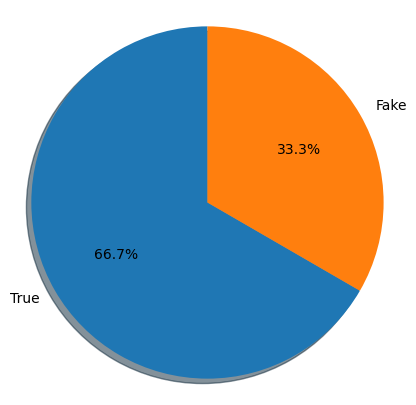

In [9]:
fig = plt.figure(figsize=(5, 5))
labels = 'True', 'Fake'
sizes = [df[df["Label"]=="TRUE"].shape[0], df[df["Label"]=="Fake"].shape[0]]
plt.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
plt.axis('equal')
plt.show()

In [10]:
# Obtain additional stopwords from nltk
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

In [11]:
# Remove stopwords and remove words with 2 or less characters
def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 2 and token not in stop_words:
            result.append(token)

    return result

In [12]:
# Apply the function to the dataframe
df['clean'] = df['Statement'].apply(preprocess)

In [13]:
# Obtain the total words present in the dataset
list_of_words = []
for i in df.clean:
    for j in i:
        list_of_words.append(j)

In [14]:
len(list_of_words)

506328

In [15]:
# Obtain the total number of unique words
total_words = len(list(set(list_of_words)))
total_words

31497

In [16]:
# join the words into a string
df['clean_joined'] = df['clean'].apply(lambda x: " ".join(x))

In [17]:
titles = [text for text in df.clean_joined]

max_len = -1
titles_len = []
for title in titles:
    max_len = max(len(title.split()), max_len)

print('Max length of the titles:', max_len)

Max length of the titles: 37


In [18]:
from sklearn.utils import shuffle
# Shuffle
df = shuffle(df).reset_index(drop=True)

In [19]:
# split data into test and train

train_val_df = df.sample(frac = 0.85, random_state = 42)
test_df = df.drop(train_val_df.index)
bard_df = test_df.sample(n=500, random_state=42)

train_df = train_val_df.sample(frac = 0.9, random_state = 42)
val_df = train_val_df.drop(train_df.index)

# Reset Index
train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

print('trainset size:', train_df.shape)
print('valset size:', val_df.shape)
print('testset size:', test_df.shape)
print('bard test size:', bard_df.shape)

trainset size: (43386, 9)
valset size: (4821, 9)
testset size: (8507, 9)
bard test size: (500, 9)


In [20]:
test_df

,id,Statement,Image,Web,Category,Date,Label,clean,clean_joined
0,4295,"ÔLove jihadÕ coined by BJP to divide nation, d...",https://images.indianexpress.com/2020/09/ashok...,INDIANEXPRESS,POLITICS,Sep-20,TRUE,"[ôlove, jihadõ, coined, bjp, divide, nation, d...",ôlove jihadõ coined bjp divide nation disturb ...
1,2440,Kerala gangrape case: NCW takes suo moto cogni...,https://www.thestatesman.com/wp-content/upload...,THESTATESMAN,VIOLENCE,Jun-20,TRUE,"[kerala, gangrape, case, ncw, takes, suo, moto...",kerala gangrape case ncw takes suo moto cogniz...
2,2784,Indian Railways to run Shramik Special trains ...,https://www.thestatesman.com/wp-content/upload...,THESTATESMAN,GOVERNMENT,May-20,TRUE,"[indian, railways, run, shramik, special, trai...",indian railways run shramik special trains dis...
3,48703,Economy And Companies In 2020: Top 10 Fake Claims,https://englishtribuneimages.blob.core.window...,AUGMENT,COVID-19,NaN,Fake,"[economy, companies, fake, claims]",economy companies fake claims
4,2752,Amid Centre vs states over migrantsÛª movemen...,https://www.thestatesman.com/wp-content/upload...,THESTATESMAN,GOVERNMENT,May-20,TRUE,"[amid, centre, states, migrants, movement, tra...",amid centre states migrants movement trains un...
...,...,...,...,...,...,...,...,...,...
8502,363,"To Mosul and back, Kerala ISIS manÛªs extraor...",https://images.indianexpress.com/2020/09/keral...,INDIANEXPRESS,VIOLENCE,Sep-20,TRUE,"[mosul, kerala, isis, man, ûªs, extraordinary,...",mosul kerala isis man ûªs extraordinary brush ...
8503,13556,Labour Ministry to launch a drive to enable un...,https://cmsimages.tribuneindia.com/gallary_con...,TRIBUNEINDIA,GOVERNMENT,Jun-20,TRUE,"[labour, ministry, launch, drive, enable, unre...",labour ministry launch drive enable unregister...
8504,17797,Delhi Police book YouTuber accused of cheating...,https://cmsimages.tribuneindia.com/gallary_con...,TRIBUNEINDIA,TERROR,Nov-20,TRUE,"[delhi, police, book, youtuber, accused, cheat...",delhi police book youtuber accused cheating ôb...
8505,49963,Fact Check: Photo Of PM Modi Alongside A Lady ...,https://cdn.cnn.com/cnnnext/dam/assets/200817...,AUGMENT,GOVERNMENT,NaN,Fake,"[fact, check, photo, modi, alongside, lady, sh...",fact check photo modi alongside lady shared cl...


In [21]:
test_df.to_csv('test.csv')

In [22]:
bard_df

,id,Statement,Image,Web,Category,Date,Label,clean,clean_joined
28831,27766,Sisodia steps in after 3 Pak Hindu refugee chi...,https://static.theprint.in/wp-content/uploads/...,THEPRINT,GOVERNMENT,Sep-19,TRUE,"[sisodia, steps, pak, hindu, refugee, children...",sisodia steps pak hindu refugee children denie...
56146,53707,FAKE: Video of IT raid on T&T law firm made vi...,https://englishtribuneimages.blob.core.windows...,AUGMENT,VIOLENCE,NaN,Fake,"[fake, video, raid, law, firm, viral, money, c...",fake video raid law firm viral money congress ...
14139,38589,Fact Check: Did a US city deploy child soldier...,https://akm-img-a-in.tosshub.com/indiatoday/im...,INDIATODAY,MISLEADING,20-Jun,Fake,"[fact, check, city, deploy, child, soldiers, q...",fact check city deploy child soldiers quell pr...
23393,51309,"No, Indian PM Modi did not receive a jumper fr...",https://static.theprint.in/wp-content/uploads/...,AUGMENT,COVID-19,NaN,Fake,"[indian, modi, receive, jumper, fifa, presiden...",indian modi receive jumper fifa president impl...
17883,2903,Tamil Nadu: 2 lawyers use forged documents to ...,https://imgk.timesnownews.com/story/iStock-105...,TIMESNOW,TERROR,Oct-20,TRUE,"[tamil, nadu, lawyers, forged, documents, secu...",tamil nadu lawyers forged documents secure bai...
...,...,...,...,...,...,...,...,...,...
56335,29889,Former Prime Minister and BJP stalwart Atal Bi...,https://static.theprint.in/wp-content/uploads/...,THEPRINT,ELECTION,Aug-18,TRUE,"[prime, minister, bjp, stalwart, atal, bihari,...",prime minister bjp stalwart atal bihari vajpay...
23863,15187,Cable operators forced to block news channel c...,https://cmsimages.tribuneindia.com/gallary_con...,TRIBUNEINDIA,POLITICS,May-20,TRUE,"[cable, operators, forced, block, news, channe...",cable operators forced block news channel crit...
46037,44765,This road is built for Chardham Yatra? Dont f...,https://newsmobile.in/wp-content/uploads/2019/...,NEWSMOBILE,VIOLENCE,19-Apr,Fake,"[road, built, chardham, yatra, fall]",road built chardham yatra fall
39692,14445,"Was advised not to speak to Rahul, claims Raji...",https://cmsimages.tribuneindia.com/gallary_con...,TRIBUNEINDIA,ELECTION,Jun-20,TRUE,"[advised, speak, rahul, claims, rajiv, bajaj]",advised speak rahul claims rajiv bajaj


In [23]:
bard_df.to_csv('bard.csv')

In [24]:
from nltk import word_tokenize

In [25]:
# Create a tokenizer to tokenize the words and create sequences of tokenized words
tokenizer = Tokenizer(num_words = total_words)
tokenizer.fit_on_texts(train_df['clean_joined'])
train_sequences = tokenizer.texts_to_sequences(train_df['clean_joined'])
test_sequences = tokenizer.texts_to_sequences(test_df['clean_joined'])
val_sequences = tokenizer.texts_to_sequences(val_df['clean_joined'])

In [26]:
# Add padding can either be maxlen = 4406 or smaller number maxlen = 40 seems to work well based on results
padded_train = pad_sequences(train_sequences,maxlen = 37, padding = 'post', truncating = 'post')
padded_test = pad_sequences(test_sequences,maxlen = 37, padding = 'post', truncating = 'post')
padded_val = pad_sequences(val_sequences,maxlen = 37, padding = 'post', truncating = 'post')

In [27]:
padded_train, padded_test, padded_val

(array([[    1,     2,    13, ...,     0,     0,     0],
        [   13,     4, 10022, ...,     0,     0,     0],
        [   55, 16264,    45, ...,     0,     0,     0],
        ...,
        [   13,    48,    24, ...,     0,     0,     0],
        [ 1300,    68,  1118, ...,     0,     0,     0],
        [ 8560,   978,   139, ...,     0,     0,     0]], dtype=int32),
 array([[3184, 2827,    6, ...,    0,    0,    0],
        [  61, 2892,   22, ...,    0,    0,    0],
        [  17,  342,  416, ...,    0,    0,    0],
        ...,
        [  11,   19,  953, ...,    0,    0,    0],
        [   1,    2,   37, ...,    0,    0,    0],
        [   7,   10,  590, ...,    0,    0,    0]], dtype=int32),
 array([[ 265, 3272,  176, ...,    0,    0,    0],
        [ 175,    7, 4661, ...,    0,    0,    0],
        [   1,    2,  265, ...,    0,    0,    0],
        ...,
        [  38,  847, 2591, ...,    0,    0,    0],
        [  31,   10, 6178, ...,    0,    0,    0],
        [ 489,   51, 2726, .

In [28]:
dummy_df = pd.get_dummies(train_df['Label'])
train_df = pd.concat([train_df, dummy_df], axis=1)
train_df

,id,Statement,Image,Web,Category,Date,Label,clean,clean_joined,Fake,TRUE
0,55955,Fact Check: Old video of overcrowded train in ...,https://www.thestatesman.com/wp-content/upload...,AUGMENT,VIOLENCE,NaN,Fake,"[fact, check, old, video, overcrowded, train, ...",fact check old video overcrowded train banglad...,True,False
1,40196,An old video of womenâs protest in Kashmir i...,https://i1.wp.com/english.factcrescendo.com/wp...,FACTCRESCENDO,VIOLENCE,19-Aug,Fake,"[old, video, womenâ, protest, kashmir, showcas...",old video womenâ protest kashmir showcased cir...,True,False
2,14058,Pakistan's PTV News fires 2 journalists for sh...,https://cmsimages.tribuneindia.com/gallary_con...,TRIBUNEINDIA,COVID-19,Jun-20,TRUE,"[pakistan, ptv, news, fires, journalists, show...",pakistan ptv news fires journalists showing ka...,False,True
3,41117,Kathua Rape: J&K Police Rubbishes Reports Publ...,https://thelogicalindian.com/h-upload/2020/01/...,THELOGICALINDIA,VIOLENCE,20-Jan,Fake,"[kathua, rape, police, rubbishes, reports, pub...",kathua rape police rubbishes reports published...,True,False
4,9365,"JEE-Main result out, 24 score 100 percentile",https://cmsimages.tribuneindia.com/gallary_con...,TRIBUNEINDIA,TERROR,Sep-20,TRUE,"[jee, main, result, score, percentile]",jee main result score percentile,False,True
...,...,...,...,...,...,...,...,...,...,...,...
43381,1734,Day after Rajasthan CM claims of Û÷higher hor...,https://www.thestatesman.com/wp-content/upload...,THESTATESMAN,ELECTION,Jul-20,TRUE,"[day, rajasthan, claims, higher, horse, tradin...",day rajasthan claims higher horse trading rate...,False,True
43382,28019,"Rahul Gandhi wants accountability, new Congres...",https://static.theprint.in/wp-content/uploads/...,THEPRINT,ELECTION,Jul-19,TRUE,"[rahul, gandhi, wants, accountability, new, co...",rahul gandhi wants accountability new congress...,False,True
43383,45358,Old image from Bihar shared as pothole-filled ...,https://static.theprint.in/wp-content/uploads...,AUGMENT,GOVERNMENT,NaN,Fake,"[old, image, bihar, shared, pothole, filled, r...",old image bihar shared pothole filled road rah...,True,False
43384,31393,Controversial Punjab DIG resigns in support of...,https://static.theprint.in/wp-content/uploads/...,THEPRINT,ELECTION,Dec-20,TRUE,"[controversial, punjab, dig, resigns, support,...",controversial punjab dig resigns support farme...,False,True


In [29]:
dummy_df = pd.get_dummies(val_df['Label'])
val_df = pd.concat([val_df, dummy_df], axis=1)
val_df

,id,Statement,Image,Web,Category,Date,Label,clean,clean_joined,Fake,TRUE
0,44712,Pakistani players were not checked during the ...,https://newsmobile.in/wp-content/uploads/2019/...,NEWSMOBILE,ELECTION,19-Jun,Fake,"[pakistani, players, checked, match, india]",pakistani players checked match india,True,False
1,22071,PM Narendra Modi interacts with recipients of ...,https://www.thestatesman.com/wp-content/upload...,THESTATESMAN,POLITICS,Jan-20,TRUE,"[narendra, modi, interacts, recipients, rashtr...",narendra modi interacts recipients rashtriya b...,False,True
2,40737,Fact Check: Pakistani website hacked by Indian...,https://newsmeter.in/wp-content/uploads/2020/0...,NEWSMETER,POLITICS,20-Sep,Fake,"[fact, check, pakistani, website, hacked, indi...",fact check pakistani website hacked indian cyb...,True,False
3,4745,"PM Modi visits LK Advani on his 93rd birthday,...",https://images.indianexpress.com/2020/11/bday....,INDIANEXPRESS,POLITICS,Nov-20,TRUE,"[modi, visits, advani, birthday, calls, ôinspi...",modi visits advani birthday calls ôinspirationõ,False,True
4,48886,Photo Of Kerala Cop Circulated As CPM Member A...,https://newsmobile.in/wp-content/uploads/2020...,AUGMENT,VIOLENCE,NaN,Fake,"[photo, kerala, cop, circulated, cpm, member, ...",photo kerala cop circulated cpm member assault...,True,False
...,...,...,...,...,...,...,...,...,...,...,...
4816,40248,Job listing attributed to World Health Organis...,https://i1.wp.com/english.factcrescendo.com/wp...,FACTCRESCENDO,MISLEADING,20-Aug,Fake,"[job, listing, attributed, world, health, orga...",job listing attributed world health organisati...,True,False
4817,6524,Arjun Rampal arrives at NCB office in Mumbai i...,https://www.thestatesman.com/wp-content/upload...,THESTATEMAN,VIOLENCE,Nov-20,TRUE,"[arjun, rampal, arrives, ncb, office, mumbai, ...",arjun rampal arrives ncb office mumbai connect...,False,True
4818,21616,UP court sends Samajwadi Party leader Azam Kha...,https://www.thestatesman.com/wp-content/upload...,THESTATESMAN,VIOLENCE,Dec-19,TRUE,"[court, sends, samajwadi, party, leader, azam,...",court sends samajwadi party leader azam khan w...,False,True
4819,29084,Maharashtra govt considering bringing an ordin...,https://static.theprint.in/wp-content/uploads/...,THEPRINT,GOVERNMENT,Jan-19,TRUE,"[maharashtra, govt, considering, bringing, ord...",maharashtra govt considering bringing ordinanc...,False,True


In [30]:
dummy_df = pd.get_dummies(test_df['Label'])
test_df = pd.concat([test_df, dummy_df], axis=1)
test_df

,id,Statement,Image,Web,Category,Date,Label,clean,clean_joined,Fake,TRUE
0,4295,"ÔLove jihadÕ coined by BJP to divide nation, d...",https://images.indianexpress.com/2020/09/ashok...,INDIANEXPRESS,POLITICS,Sep-20,TRUE,"[ôlove, jihadõ, coined, bjp, divide, nation, d...",ôlove jihadõ coined bjp divide nation disturb ...,False,True
1,2440,Kerala gangrape case: NCW takes suo moto cogni...,https://www.thestatesman.com/wp-content/upload...,THESTATESMAN,VIOLENCE,Jun-20,TRUE,"[kerala, gangrape, case, ncw, takes, suo, moto...",kerala gangrape case ncw takes suo moto cogniz...,False,True
2,2784,Indian Railways to run Shramik Special trains ...,https://www.thestatesman.com/wp-content/upload...,THESTATESMAN,GOVERNMENT,May-20,TRUE,"[indian, railways, run, shramik, special, trai...",indian railways run shramik special trains dis...,False,True
3,48703,Economy And Companies In 2020: Top 10 Fake Claims,https://englishtribuneimages.blob.core.window...,AUGMENT,COVID-19,NaN,Fake,"[economy, companies, fake, claims]",economy companies fake claims,True,False
4,2752,Amid Centre vs states over migrantsÛª movemen...,https://www.thestatesman.com/wp-content/upload...,THESTATESMAN,GOVERNMENT,May-20,TRUE,"[amid, centre, states, migrants, movement, tra...",amid centre states migrants movement trains un...,False,True
...,...,...,...,...,...,...,...,...,...,...,...
8502,363,"To Mosul and back, Kerala ISIS manÛªs extraor...",https://images.indianexpress.com/2020/09/keral...,INDIANEXPRESS,VIOLENCE,Sep-20,TRUE,"[mosul, kerala, isis, man, ûªs, extraordinary,...",mosul kerala isis man ûªs extraordinary brush ...,False,True
8503,13556,Labour Ministry to launch a drive to enable un...,https://cmsimages.tribuneindia.com/gallary_con...,TRIBUNEINDIA,GOVERNMENT,Jun-20,TRUE,"[labour, ministry, launch, drive, enable, unre...",labour ministry launch drive enable unregister...,False,True
8504,17797,Delhi Police book YouTuber accused of cheating...,https://cmsimages.tribuneindia.com/gallary_con...,TRIBUNEINDIA,TERROR,Nov-20,TRUE,"[delhi, police, book, youtuber, accused, cheat...",delhi police book youtuber accused cheating ôb...,False,True
8505,49963,Fact Check: Photo Of PM Modi Alongside A Lady ...,https://cdn.cnn.com/cnnnext/dam/assets/200817...,AUGMENT,GOVERNMENT,NaN,Fake,"[fact, check, photo, modi, alongside, lady, sh...",fact check photo modi alongside lady shared cl...,True,False


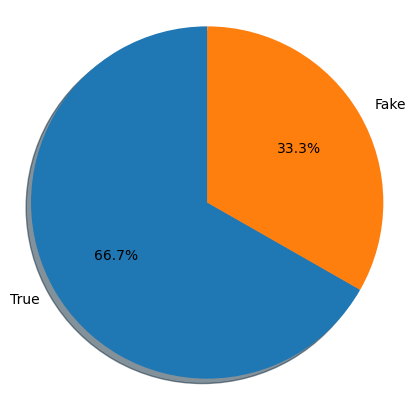

In [31]:
fig = plt.figure(figsize=(5, 5))
labels = 'True', 'Fake'
sizes = [train_df[train_df["Label"]=="TRUE"].shape[0], train_df[train_df["Label"]=="Fake"].shape[0]]
plt.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
plt.axis('equal')
plt.show()

# LSTM

In [28]:
model1=Sequential()
model1.add(Embedding(total_words,output_dim = 128))

model1.add(LSTM(128))

model1.add(Dense(128, activation = 'relu'))
model1.add(Dense(1,activation='sigmoid'))
model1.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
print(model1.summary())

2023-12-08 01:09:50.223536: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2023-12-08 01:09:50.223577: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2023-12-08 01:09:50.223583: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2023-12-08 01:09:50.224019: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-12-08 01:09:50.224398: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 128)         4031616   
                                                                 
 lstm (LSTM)                 (None, 128)               131584    
                                                                 
 dense (Dense)               (None, 128)               16512     
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 4179841 (15.94 MB)
Trainable params: 4179841 (15.94 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [29]:
y_train = np.asarray(train_df['TRUE'], dtype=np.float32)
y_val = np.asarray(val_df['TRUE'], dtype=np.float32)

y_train, y_val

(array([0., 1., 0., ..., 0., 1., 1.], dtype=float32),
 array([1., 0., 0., ..., 1., 0., 0.], dtype=float32))

In [30]:
model1.fit(padded_train, y_train, batch_size = 64, validation_data=(padded_val, y_val), epochs = 2)

Epoch 1/2


2023-12-08 01:10:05.857993: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-12-08 01:10:06.159733: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-12-08 01:10:06.501727: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


678/678 [==============================] - ETA: 0s - loss: 0.3575 - accuracy: 0.8725

2023-12-08 01:10:33.901539: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-12-08 01:10:34.003838: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


678/678 [==============================] - 30s 42ms/step - loss: 0.3575 - accuracy: 0.8725 - val_loss: 0.2851 - val_accuracy: 0.9147
Epoch 2/2
678/678 [==============================] - 25s 37ms/step - loss: 0.1988 - accuracy: 0.9366 - val_loss: 0.1501 - val_accuracy: 0.9486


In [31]:
results = model1.evaluate(padded_train, y_train)
results

1356/1356 [==============================] - 13s 9ms/step - loss: 0.1008 - accuracy: 0.9669


[0.10078564286231995, 0.9668556451797485]

In [38]:
prediction=(model1.predict(padded_test) > 0.5).astype("int32")

266/266 [==============================] - 2s 7ms/step


LSTM Model Accuracy :  0.9445162807100035
              precision    recall  f1-score   support

       False       0.96      0.87      0.91      2863
        True       0.94      0.98      0.96      5644

    accuracy                           0.94      8507
   macro avg       0.95      0.93      0.94      8507
weighted avg       0.95      0.94      0.94      8507



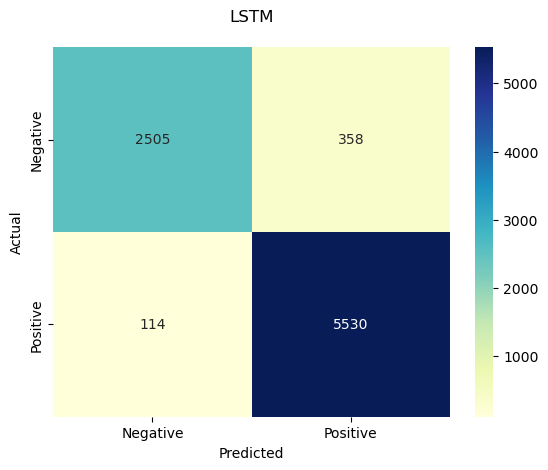

In [49]:
# Getting The Accuracy
from sklearn.metrics import accuracy_score
y_test = np.asarray(test_df['TRUE'])

accuracy = accuracy_score(list(y_test), prediction)

print("LSTM Model Accuracy : ", accuracy)


import seaborn as sns
import matplotlib.pyplot as plt

# Getting The Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(list(y_test), prediction)

df_cm = pd.DataFrame(cm, index=['Negative', 'Positive'], columns=['Negative', 'Positive'])
plt.title("LSTM\n")
sns.heatmap(df_cm, annot=True, fmt="d", cmap="YlGnBu")
plt.ylabel("Actual")
plt.xlabel("Predicted")

from sklearn.metrics import classification_report
print(classification_report(y_test, prediction))

# BiLSTM

In [50]:
# Sequential Model
model = Sequential()

# embeddidng layer
model.add(Embedding(total_words, output_dim = 128))
# model.add(Embedding(total_words, output_dim = 240))


# Bi-Directional RNN and LSTM
model.add(Bidirectional(LSTM(128)))

# Dense layers
model.add(Dense(128, activation = 'relu'))
model.add(Dense(1,activation= 'sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 128)         4031616   
                                                                 
 bidirectional (Bidirection  (None, 256)               263168    
 al)                                                             
                                                                 
 dense_2 (Dense)             (None, 128)               32896     
                                                                 
 dense_3 (Dense)             (None, 1)                 129       
                                                                 
Total params: 4327809 (16.51 MB)
Trainable params: 4327809 (16.51 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [51]:
y_train = np.asarray(train_df['TRUE'])
y_val = np.asarray(val_df['TRUE'])

In [52]:
model.fit(padded_train, y_train, batch_size = 64, validation_data=(padded_val, y_val), epochs = 2)

Epoch 1/2


2023-12-08 01:43:37.550282: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-12-08 01:43:38.008856: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-12-08 01:43:38.036985: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-12-08 01:43:38.439209: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-12-08 01:43:38.483904: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


678/678 [==============================] - ETA: 0s - loss: 0.2023 - acc: 0.9259

2023-12-08 01:44:14.638139: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-12-08 01:44:14.795092: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-12-08 01:44:14.815152: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


678/678 [==============================] - 40s 55ms/step - loss: 0.2023 - acc: 0.9259 - val_loss: 0.1506 - val_acc: 0.9484
Epoch 2/2
678/678 [==============================] - 36s 53ms/step - loss: 0.1044 - acc: 0.9635 - val_loss: 0.1530 - val_acc: 0.9492


In [53]:
results = model.evaluate(padded_train, y_train)
results

1356/1356 [==============================] - 20s 14ms/step - loss: 0.0561 - acc: 0.9803


[0.056116435676813126, 0.9802701473236084]

2023-12-08 01:45:12.845007: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-12-08 01:45:12.974257: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-12-08 01:45:12.994286: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


266/266 [==============================] - 4s 10ms/step
BiLSTM Model Accuracy :  0.9467497355119313
              precision    recall  f1-score   support

       False       0.95      0.89      0.92      2863
        True       0.94      0.98      0.96      5644

    accuracy                           0.95      8507
   macro avg       0.95      0.93      0.94      8507
weighted avg       0.95      0.95      0.95      8507



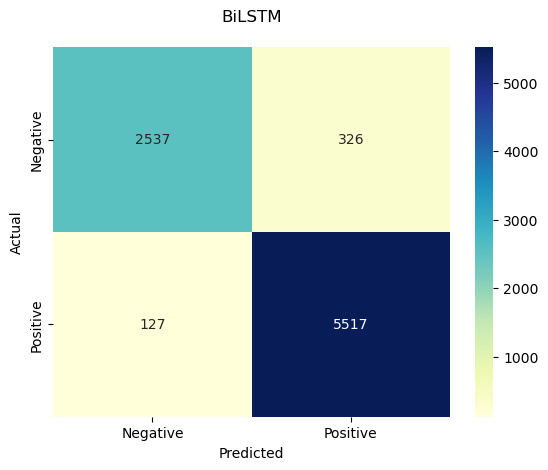

In [54]:
prediction=(model.predict(padded_test) > 0.5).astype("int32")

# Getting The Accuracy
from sklearn.metrics import accuracy_score
y_test = np.asarray(test_df['TRUE'])

accuracy = accuracy_score(list(y_test), prediction)

print("BiLSTM Model Accuracy : ", accuracy)


import seaborn as sns
import matplotlib.pyplot as plt

# Getting The Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(list(y_test), prediction)

df_cm = pd.DataFrame(cm, index=['Negative', 'Positive'], columns=['Negative', 'Positive'])
plt.title("BiLSTM\n")
sns.heatmap(df_cm, annot=True, fmt="d", cmap="YlGnBu")
plt.ylabel("Actual")
plt.xlabel("Predicted")

from sklearn.metrics import classification_report
print(classification_report(y_test, prediction))

# CNN + LSTM

In [55]:
model4=Sequential()
model4.add(Embedding(total_words, output_dim = 128))

model4.add(Conv1D(32, 5, activation='relu'))
model4.add(MaxPool1D())

model4.add(LSTM(128))

model4.add(Dense(128, activation = 'relu'))
model4.add(Dense(1,activation='sigmoid'))
model4.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
print(model4.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, None, 128)         4031616   
                                                                 
 conv1d (Conv1D)             (None, None, 32)          20512     
                                                                 
 max_pooling1d (MaxPooling1  (None, None, 32)          0         
 D)                                                              
                                                                 
 lstm_2 (LSTM)               (None, 128)               82432     
                                                                 
 dense_4 (Dense)             (None, 128)               16512     
                                                                 
 dense_5 (Dense)             (None, 1)                 129       
                                                      

In [56]:
y_train = np.asarray(train_df['TRUE'])
y_val = np.asarray(val_df['TRUE'])

model4.fit(padded_train, y_train, batch_size = 64, validation_data=(padded_val, y_val), epochs = 2)

Epoch 1/2


2023-12-08 01:45:17.060478: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-12-08 01:45:17.429205: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-12-08 01:45:17.774140: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


678/678 [==============================] - ETA: 0s - loss: 0.2114 - acc: 0.9231

2023-12-08 01:45:43.663311: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-12-08 01:45:43.810690: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


678/678 [==============================] - 29s 39ms/step - loss: 0.2114 - acc: 0.9231 - val_loss: 0.1479 - val_acc: 0.9529
Epoch 2/2
678/678 [==============================] - 23s 34ms/step - loss: 0.0928 - acc: 0.9704 - val_loss: 0.1462 - val_acc: 0.9521


In [57]:
results = model4.evaluate(padded_train, y_train)
results

1356/1356 [==============================] - 12s 9ms/step - loss: 0.0536 - acc: 0.9854


[0.053594719618558884, 0.9854331016540527]

2023-12-08 01:46:20.803358: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-12-08 01:46:20.923008: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


266/266 [==============================] - 2s 6ms/step
CNN + LSTM Model Accuracy :  0.9495709415775244
              precision    recall  f1-score   support

       False       0.94      0.91      0.92      2863
        True       0.95      0.97      0.96      5644

    accuracy                           0.95      8507
   macro avg       0.95      0.94      0.94      8507
weighted avg       0.95      0.95      0.95      8507



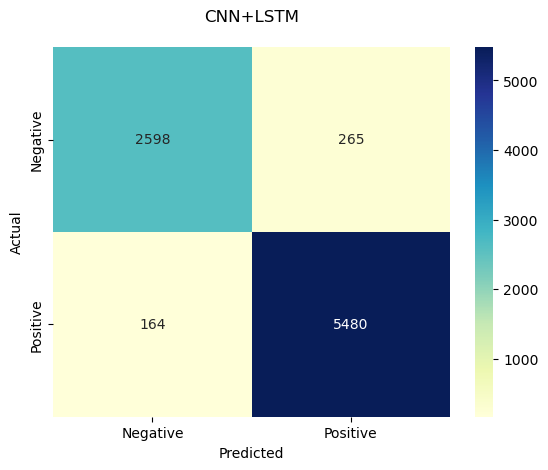

In [58]:
prediction=(model4.predict(padded_test) > 0.5).astype("int32")

# Getting The Accuracy
from sklearn.metrics import accuracy_score
y_test = np.asarray(test_df['TRUE'])

accuracy = accuracy_score(list(y_test), prediction)

print("CNN + LSTM Model Accuracy : ", accuracy)


import seaborn as sns
import matplotlib.pyplot as plt

# Getting The Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(list(y_test), prediction)

df_cm = pd.DataFrame(cm, index=['Negative', 'Positive'], columns=['Negative', 'Positive'])
plt.title("CNN+LSTM\n")
sns.heatmap(df_cm, annot=True, fmt="d", cmap="YlGnBu")
plt.ylabel("Actual")
plt.xlabel("Predicted")

from sklearn.metrics import classification_report
print(classification_report(y_test, prediction))

# CNN + BiLSTM

In [59]:
model3=Sequential()
model3.add(Embedding(total_words, output_dim = 128))

model3.add(Conv1D(32, 5, activation='relu'))
model3.add(MaxPool1D())

model3.add(Bidirectional(LSTM(128)))

model3.add(Dense(128, activation = 'relu'))
model3.add(Dense(1,activation='sigmoid'))
model3.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
print(model3.summary())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, None, 128)         4031616   
                                                                 
 conv1d_1 (Conv1D)           (None, None, 32)          20512     
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, None, 32)          0         
 g1D)                                                            
                                                                 
 bidirectional_1 (Bidirecti  (None, 256)               164864    
 onal)                                                           
                                                                 
 dense_6 (Dense)             (None, 128)               32896     
                                                                 
 dense_7 (Dense)             (None, 1)                

In [60]:
y_train = np.asarray(train_df['TRUE'])
y_val = np.asarray(val_df['TRUE'])

model3.fit(padded_train, y_train, batch_size = 64, validation_data=(padded_val, y_val), epochs = 2)

Epoch 1/2


2023-12-08 01:46:24.556439: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-12-08 01:46:25.057757: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-12-08 01:46:25.084587: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-12-08 01:46:25.482783: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-12-08 01:46:25.524534: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


678/678 [==============================] - ETA: 0s - loss: 0.2069 - accuracy: 0.9229

2023-12-08 01:47:00.785341: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-12-08 01:47:00.996627: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-12-08 01:47:01.017900: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


678/678 [==============================] - 39s 54ms/step - loss: 0.2069 - accuracy: 0.9229 - val_loss: 0.1435 - val_accuracy: 0.9525
Epoch 2/2
678/678 [==============================] - 31s 46ms/step - loss: 0.0918 - accuracy: 0.9680 - val_loss: 0.1576 - val_accuracy: 0.9479


In [61]:
results = model3.evaluate(padded_train, y_train)
results

1356/1356 [==============================] - 18s 13ms/step - loss: 0.0510 - accuracy: 0.9816


[0.050996553152799606, 0.9815838932991028]

2023-12-08 01:47:51.626939: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-12-08 01:47:51.797978: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-12-08 01:47:51.817512: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


266/266 [==============================] - 3s 10ms/step
CNN+BiLSTM Model Accuracy :  0.9445162807100035
              precision    recall  f1-score   support

       False       0.94      0.89      0.92      2863
        True       0.94      0.97      0.96      5644

    accuracy                           0.94      8507
   macro avg       0.94      0.93      0.94      8507
weighted avg       0.94      0.94      0.94      8507



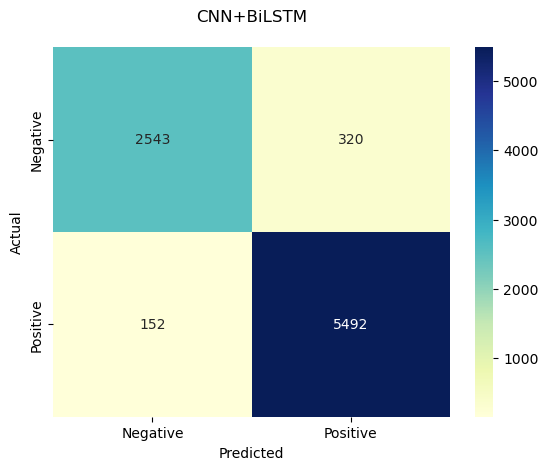

In [62]:
prediction=(model3.predict(padded_test) > 0.5).astype("int32")

# Getting The Accuracy
from sklearn.metrics import accuracy_score
y_test = np.asarray(test_df['TRUE'])

accuracy = accuracy_score(list(y_test), prediction)

print("CNN+BiLSTM Model Accuracy : ", accuracy)

import seaborn as sns
import matplotlib.pyplot as plt

# Getting The Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(list(y_test), prediction)

df_cm = pd.DataFrame(cm, index=['Negative', 'Positive'], columns=['Negative', 'Positive'])
plt.title("CNN+BiLSTM\n")
sns.heatmap(df_cm, annot=True, fmt="d", cmap="YlGnBu")
plt.ylabel("Actual")
plt.xlabel("Predicted")

from sklearn.metrics import classification_report
print(classification_report(y_test, prediction))

# BERT

In [1]:
! pip install transformers

In [32]:
from transformers import BertTokenizer, TFBertForSequenceClassification, TFTrainer, TFTrainingArguments
from transformers import DistilBertTokenizer
from transformers import TFDistilBertForSequenceClassification
from transformers import TFDistilBertForSequenceClassification, TFTrainer, TFTrainingArguments
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

# Define a function to compute metrics
def compute_metrics(p):
    predictions, labels = p

    accuracy = accuracy_score(labels, predictions.argmax(axis=1))
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions.argmax(axis=1), average='weighted')

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }

model = TFDistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=2)

train_texts = train_df['clean_joined'].tolist()
test_texts = test_df['clean_joined'].tolist()

tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

train_encodings = tokenizer(train_texts, truncation = True, padding = True  )
test_encodings = tokenizer(test_texts, truncation=True, padding=True )

train_labels = tf.convert_to_tensor(train_df['TRUE'].tolist())
test_labels = tf.convert_to_tensor(test_df['TRUE'].tolist())

train_dataset = tf.data.Dataset.from_tensor_slices((dict(train_encodings), train_labels))
test_dataset = tf.data.Dataset.from_tensor_slices((dict(test_encodings), test_labels))


training_args = TFTrainingArguments(
    output_dir='./results',
    num_train_epochs=2,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    warmup_steps=500,
    weight_decay=1e-5,
    logging_dir='./logs',
    eval_steps=100
)

with training_args.strategy.scope():
    trainer_model = TFDistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels = 2 )

trainer = TFTrainer(
    model=trainer_model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics
)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_projector.bias']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 